In [2]:
from datetime import datetime
import time

# This function takes as input the response for a single survey, and transforms it into a flat dictionary
def flatten(item):
    fmt = "%Y-%m-%dT%H:%M:%S.%fZ"
    
    hit_answer_date = datetime.strptime(item["date"], fmt)
    hit_creation_str = item.get("hitCreationDate")
    
    if hit_creation_str is None: 
        hit_creation_date = None 
        diff = None
    else:
        hit_creation_date = datetime.strptime(hit_creation_str, fmt)
        # convert to unix timestamp
        hit_date_ts = time.mktime(hit_creation_date.timetuple())
        answer_date_ts = time.mktime(hit_answer_date.timetuple())
        diff = int(answer_date_ts-hit_date_ts)
    
    result = {
        "worker_id": str(item["workerId"]),
        "gender": str(item["answers"]["gender"]),
        "household_income": str(item["answers"]["householdIncome"]),
        "household_size": str(item["answers"]["householdSize"]),
        "marital_status": str(item["answers"].get("maritalStatus")),
        "year_of_birth": int(item["answers"]["yearOfBirth"]),
        "location_city": str(item.get("locationCity")),
        "location_region": str(item.get("locationRegion")),
        "location_country": str(item["locationCountry"]),
        "hit_answered_date": hit_answer_date,
        "hit_creation_date": hit_creation_date,
        "post_to_completion_secs": diff
    }
    return result

In [4]:
# The code below retrieves all the responses from the Demographics API
# Since we cannot get all the responses at once, we fetch a few thousand
# records at a time, until fetching them all

import requests
import json

limit = 5000

# The API call that returns the last survey responses
baseurl = "https://mturk-surveys.appspot.com/" + \
    "_ah/api/survey/v1/survey/demographics/answers?limit=" + str(limit)

# This is the cursor variable, used to retrieve more pages of results
nextPageToken = None

# We store the results in this list
results = []

while True:
    if nextPageToken == None:
        url = baseurl
    else:
        url = baseurl + "&cursor=" + nextPageToken

    resp = requests.get(url)
    if resp.status_code == 200:
        data = json.loads(resp.text)
        items = data.get("items")
        if items == None:
            break
        print ("Retrieved ", len(items), " responses")
        responses = [flatten(item) for item in items]
        results.extend(responses)
        print ("Total of ", len(results), " responses in our data")
    else:
        print ("Something went wrong with the network call")

    nextPageToken = data.get("nextPageToken")
    if nextPageToken == None:
        break


Retrieved  5000  responses
Total of  5000  responses in our data
Retrieved  5000  responses
Total of  10000  responses in our data
Retrieved  5000  responses
Total of  15000  responses in our data
Retrieved  5000  responses
Total of  20000  responses in our data
Retrieved  5000  responses
Total of  25000  responses in our data
Retrieved  5000  responses
Total of  30000  responses in our data
Retrieved  5000  responses
Total of  35000  responses in our data
Retrieved  5000  responses
Total of  40000  responses in our data
Retrieved  5000  responses
Total of  45000  responses in our data
Retrieved  5000  responses
Total of  50000  responses in our data
Retrieved  2492  responses
Total of  52492  responses in our data


In [5]:
# Let's print the total number of retrieved responses
print (len(results))

52492


In [6]:
import pandas as pd
df = pd.DataFrame(results)
# Let's save the file as a CSV
df.to_csv("mturk_surveys.csv")

In [1]:
import pandas as pd
df = pd.read_csv("mturk_surveys.csv")
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df["hit_creation_date"]=pd.to_datetime(df["hit_creation_date"])
df["household_income"]=df["household_income"].astype("category")
df["household_size"]=df["household_size"].astype("category")
df["location_country"]=df["location_country"].astype("category")
df["marital_status"]=df["marital_status"].astype("category")
df['date'] = map(lambda x : x.date(), df['hit_answered_date'])
df['time'] = map(lambda x : x.time(), df['hit_answered_date'])

In [2]:
import datetime
minDate = min(df['hit_answered_date'])
maxDate = max(df['hit_answered_date'])
days = (maxDate - minDate).days
print (minDate)
print (maxDate)
print (days)
df.head(5)

2015-03-26 11:47:28.877000
2016-09-14 17:37:11.297000
538


,Unnamed: 0,gender,hit_answered_date,hit_creation_date,household_income,household_size,location_city,location_country,location_region,marital_status,post_to_completion_secs,worker_id,year_of_birth,date,time
0,0,female,2016-09-14 17:37:11.297,2016-09-14 17:35:14,"$40,000-$59,999",1,mount holly,US,nj,divorced,117.0,a013d8ba79229f477b5b045bf35c7d57,1956,<map object at 0x00000274DA90E518>,<map object at 0x00000274DA90E710>
1,1,male,2016-09-14 17:29:09.539,2016-09-14 17:20:14,"Less than $10,000",2,pune,IN,mh,single,535.0,4958cd4059bd09a144c2698d50f5bc60,1992,<map object at 0x00000274DA90E518>,<map object at 0x00000274DA90E710>
2,2,female,2016-09-14 17:13:35.428,2016-09-14 16:20:14,"Less than $10,000",4,caracas,VE,a,divorced,3201.0,0a79a3e3ea28284e7a92ce0ddaa05e06,1978,<map object at 0x00000274DA90E518>,<map object at 0x00000274DA90E710>
3,3,female,2016-09-14 17:10:54.723,2016-09-14 17:05:13,"$75,000-$99,999",3,scottsdale,US,az,cohabitating,341.0,1079d94e2374ade52af1de09232c9797,1963,<map object at 0x00000274DA90E518>,<map object at 0x00000274DA90E710>
4,4,male,2016-09-14 16:52:20.792,2016-09-14 16:50:13,"Less than $10,000",4,ambala,IN,hr,single,127.0,897b71b78803b47bc19d0d31ff91856e,1993,<map object at 0x00000274DA90E518>,<map object at 0x00000274DA90E710>


In [3]:
def getWorkerIDs(df, startDate, endDate):
    '''
    Returns the set of distinct workers that participated in the surveys between the two dates
    '''
    return set(df["worker_id"][(df['hit_answered_date']>=startDate) & (df['hit_answered_date']<endDate)])


In [4]:
# We will consider a period of "window" days as one catching period.
window = 14
dates = set(df['hit_answered_date'])

min_date = min(dates)
max_date = max(dates)

data = {}
worker_ids = {}
startDate = min_date
period = 0
while startDate < max_date:
    endDate = startDate + datetime.timedelta(days=window)
    period_captured_ids = getWorkerIDs(df, startDate, endDate)
    worker_ids[period] = period_captured_ids
    
    before_captured_ids = getWorkerIDs(df, min_date, startDate)
    after_captured_ids = getWorkerIDs(df, endDate, max_date)
    before_captured = len(before_captured_ids)
    period_marked = len(period_captured_ids & before_captured_ids)
    period_unmarked = len(period_captured_ids) - period_marked
    period_total = len(period_captured_ids)
    
    period_ids_captured_later = len(period_captured_ids & after_captured_ids)
    before_captured_ids_captured_later = len(before_captured_ids & after_captured_ids)
    
    period_survival = 1.0*period_ids_captured_later / period_total
    if before_captured>0:
        before_survival = 1.0*before_captured_ids_captured_later / before_captured
    else:
        before_survival = -1

    if before_survival>0:
        ratio = period_survival / before_survival
    else:
        ratio = -1
    
    new_ids_captured_later = len(after_captured_ids) - len(after_captured_ids & period_captured_ids)
    period_growth = 1.0*new_ids_captured_later / period_total

 
    data[period] = {"period_id": period,
                  "before_captured": before_captured,
                  "period_captured": period_total, 
                  "period_marked": period_marked,
                  "period_unmarked": period_unmarked,
                  "startDate": startDate,
                    "endDate": endDate,
                    "survival":period_survival,
                    "growth":period_growth
                 } 

    startDate = endDate
    period += 1

jollyseber = pd.DataFrame(data)
jollyseber.T

,before_captured,endDate,growth,period_captured,period_id,period_marked,period_unmarked,startDate,survival
0,0,2015-04-09 11:47:28.877000,21.1115,1300,0,0,1300,2015-03-26 11:47:28.877000,0.703077
1,1300,2015-04-23 11:47:28.877000,20.3708,1327,1,0,1327,2015-04-09 11:47:28.877000,0.537302
2,2627,2015-05-07 11:47:28.877000,19.814,1333,2,168,1165,2015-04-23 11:47:28.877000,0.490623
3,3792,2015-05-21 11:47:28.877000,19.1384,1344,3,286,1058,2015-05-07 11:47:28.877000,0.526786
4,4850,2015-06-04 11:47:28.877000,19.3778,1297,4,322,975,2015-05-21 11:47:28.877000,0.497301
5,5825,2015-06-18 11:47:28.877000,18.223,1341,5,413,928,2015-06-04 11:47:28.877000,0.542878
6,6753,2015-07-02 11:47:28.877000,17.8079,1338,6,392,946,2015-06-18 11:47:28.877000,0.472347
7,7699,2015-07-16 11:47:28.877000,20.1766,1155,7,423,732,2015-07-02 11:47:28.877000,0.522944
8,8431,2015-07-30 11:47:28.877000,16.8818,1337,8,499,838,2015-07-16 11:47:28.877000,0.539267
9,9269,2015-08-13 11:47:28.877000,16.3821,1340,9,540,800,2015-07-30 11:47:28.877000,0.527612


In [5]:
period = len(worker_ids.keys())
survival_probs = []
for period_from in range(0,period-1):
    period_from_ids = worker_ids.get(period_from)
    for period_to in range(0,period-1):
        date_diff = (data[period_to]['startDate'] - data[period_from]['startDate']).days
        if date_diff<=0:
            continue
        buffr = (data[period_to]['startDate'] - data[period_from]['endDate']).days
        if buffr < 30:
            continue
        period_to_ids = worker_ids.get(period_to)
        intersection = period_from_ids & period_to_ids
        survival_likelihood = 1.0*len(intersection) / len(period_from_ids)
        survival_probs.append( { "diff":date_diff, "survival": survival_likelihood} )
        
survival_df = pd.DataFrame(survival_probs)


# Adding the survival rate to the model

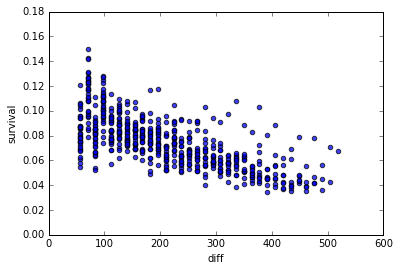

In [6]:
# We plot the survival rate with respect to the days different
%matplotlib inline
survival_df.plot.scatter(x='diff', y='survival', alpha=0.75)

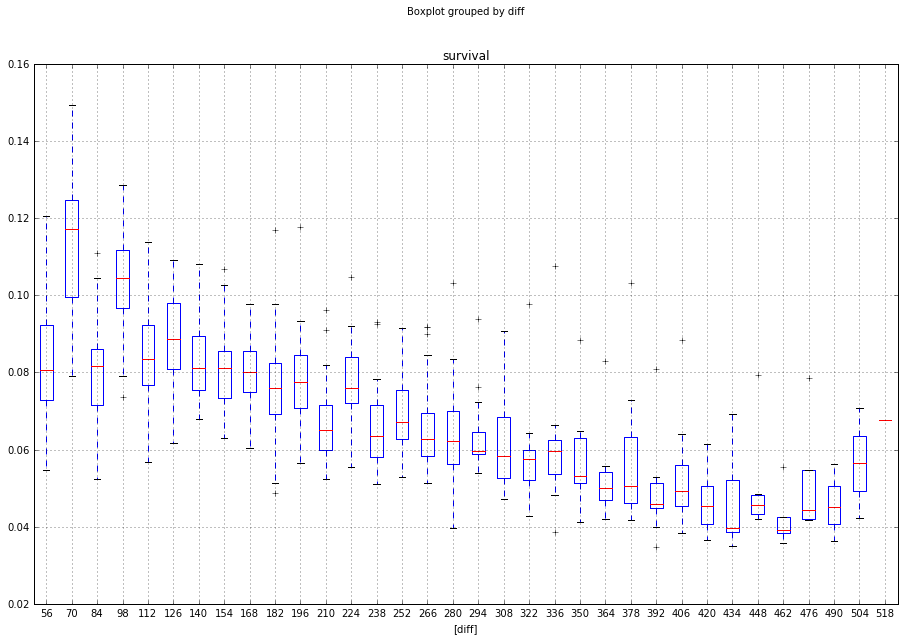

In [7]:
survival_df[['diff','survival']].boxplot(by='diff', figsize=(15,10))

In [8]:
# Assuming an exponential survival function S(t) = K * exp(-lambda * t)
import math
import statsmodels.formula.api as sm
survival_df['logsurvival'] = list(map(lambda x : math.log(x), survival_df['survival']))
result = sm.ols(formula="logsurvival ~ diff", data=survival_df).fit()
print (result.params)

Intercept   -2.245445
diff        -0.001807
dtype: float64


In [9]:
# We fit the survivial function with respect to the time
fit_K = math.exp(result.params['Intercept'])
fit_l = -result.params['diff']

print ("K =", fit_K)
print ("labda =", fit_l)
print ("Half-life =", math.log(2)/fit_l)


K = 0.10588045150720704
labda = 0.00180745730947
Half-life = 383.492974871


In [10]:
# Here we define the survival rate function
def survival(t, l = fit_l):
    return np.exp(-fit_l*t)

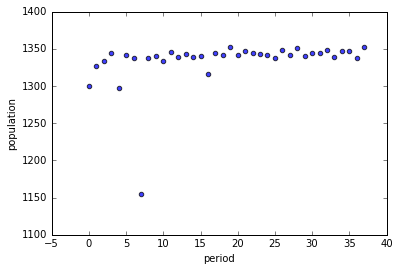

In [11]:
# Next we plot the population for each period
population = []
for i in range(0,period-1):
    pop = jollyseber.T["period_captured"][i]
    population.append( { "period":i,"population":pop} )
        
population_df = pd.DataFrame(population)
population_df.plot.scatter(x='period', y='population', alpha=0.75)

From the plot, we can see that the population is somewhat steady with regard to period, however, there is a obvious trend that the population has a moderate growth as the period increase. Additionally, we can clearly see that there is an outlier between period 5 and 10 that has a unreasonable low population.
Next, we are trying to add one parameter called "g" that adjust the population change.

# Adding the population growth rate to the model

In [12]:
# We calculate the growth rate with respect to days different

growth_probs = []
for period_from in range(0,period-1):
    period_from_ids = worker_ids.get(period_from)
    for period_to in range(0,period-1):
        date_diff = (data[period_to]['startDate'] - data[period_from]['startDate']).days
        if date_diff<=0:
            continue
        buffr = (data[period_to]['startDate'] - data[period_from]['endDate']).days
        if buffr < 30:
            continue
        period_to_ids = worker_ids.get(period_to)
        difference = len(period_to_ids) - len (period_from_ids)
        growth_likelihood = 1.0*difference/len(period_from_ids)
        growth_probs.append( { "diff":date_diff,"growth_rate":growth_likelihood} )
        
growth_df = pd.DataFrame(growth_probs)

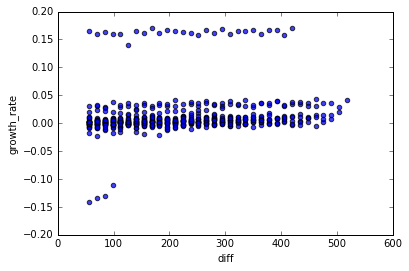

In [13]:
growth_df.plot.scatter(x='diff', y='growth_rate', alpha=0.75)

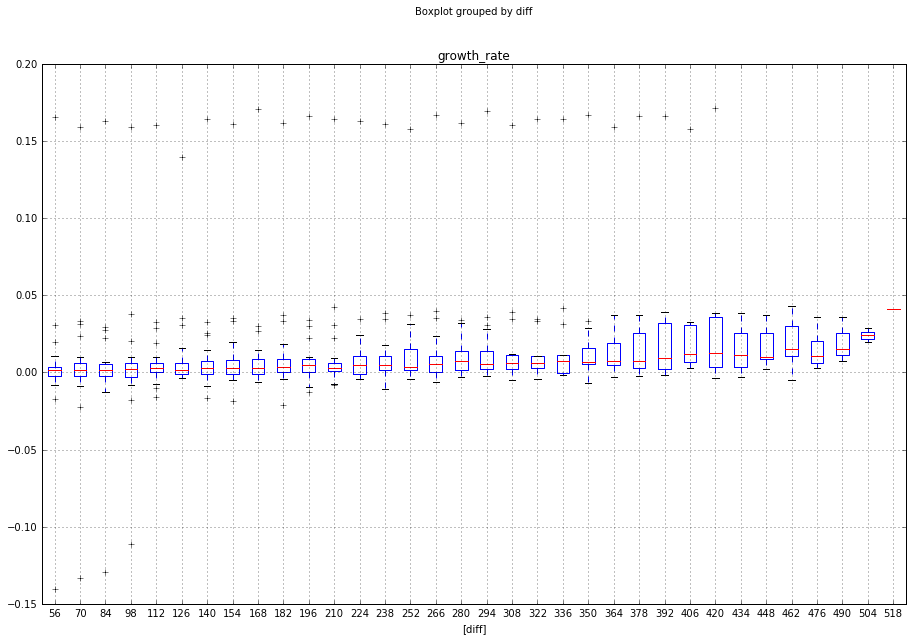

In [14]:
# From the plot, we see that the "outlier point" makes the result odd, we then make the bar plot to make it clear
growth_df[['diff','growth_rate']].boxplot(by='diff', figsize=(15,10))

# Checking for the "Birth rate"

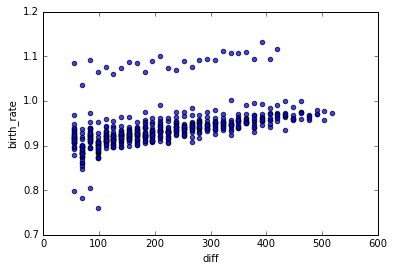

In [15]:
birth_probs = []
for period_from in range(0,period-1):
    period_from_ids = worker_ids.get(period_from)
    for period_to in range(0,period-1):
        date_diff = (data[period_to]['startDate'] - data[period_from]['startDate']).days
        if date_diff<=0:
            continue
        buffr = (data[period_to]['startDate'] - data[period_from]['endDate']).days
        if buffr < 30:
            continue
            period_to_ids = worker_ids.get(period_to)
            
        period_to_ids = worker_ids.get(period_to)
        intersection = period_from_ids & period_to_ids
        birth_likelihood = 1.0*len(period_to_ids-intersection)/len(period_from_ids)  
        birth_probs.append( { "diff":date_diff,"birth_rate":birth_likelihood} )
        
birth_df = pd.DataFrame(birth_probs)

birth_df.plot.scatter(x='diff', y='birth_rate', alpha=0.75)

# Checking for the "Death rate"

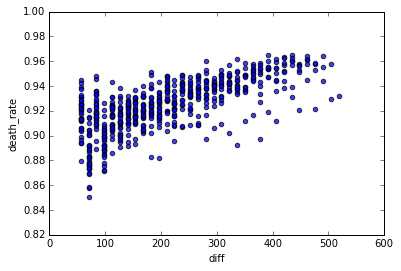

In [16]:
death_probs = []
for period_from in range(0,period-1):
    period_from_ids = worker_ids.get(period_from)
    for period_to in range(0,period-1):
        date_diff = (data[period_to]['startDate'] - data[period_from]['startDate']).days
        if date_diff<=0:
            continue
        buffr = (data[period_to]['startDate'] - data[period_from]['endDate']).days
        if buffr < 30:
            continue
            period_to_ids = worker_ids.get(period_to)
            
        period_to_ids = worker_ids.get(period_to)
        intersection = period_from_ids & period_to_ids
        death_likelihood = 1.0*len(period_from_ids-intersection)/len(period_from_ids)  
        death_probs.append( { "diff":date_diff,"death_rate":death_likelihood} )
        
death_df = pd.DataFrame(death_probs)

death_df.plot.scatter(x='diff', y='death_rate', alpha=0.75)

From the below two plots, we can see that both the "birth rate" and the "death rate" are relatively high. And combine the two components together, it is just the population variation. So for the following part, we consider the population change as a compact part without consider the birth and death seperatly.

# Linear regression to growth rate

In [17]:
# From the plot, we see the population is increasing along with the days different becoming longer. We first try to fit the tendency with liner model
import numpy as np
z1 = np.polyfit(growth_df['diff'], growth_df['growth_rate'], 1)
p1 = np.poly1d(z1)
print (z1)
print (p1)

[  5.77292002e-05   6.34712780e-04]
 
5.773e-05 x + 0.0006347


In [18]:
# Define the growth function
def growth(t, l = z1):
    return z1[0]*t+z1[1]

In [19]:
# Define the capture recapture function with adding the parameter "g"
def capture_recapture_with_survival_and_growth(df, groupAstart, groupBstart, window):
    
    groupAend = groupAstart + datetime.timedelta(days=window)
    groupBend = groupBstart + datetime.timedelta(days=window)
    diff_days = (groupBstart - groupAstart).days
    workersA = getWorkerIDs(df, groupAstart, groupAend)
    workersB = getWorkerIDs(df, groupBstart, groupBend)
    union = workersA | workersB
    intersection = workersA & workersB
    if len(intersection) > 0:
        capture_recapture_estimate = len(workersA) * len(workersB) * survival(diff_days)  / len(intersection) * (1+ growth(diff_days))
    else:
        capture_recapture_estimate = None

    return {
        "window" : window,
        "groupA_start" : groupAstart,
        "groupA_end" : groupAend,
        "groupB_start" : groupBstart,
        "groupB_end" : groupBend,
        "date_diff": diff_days,
        "workers_A" : len(workersA),
        "workers_B" : len(workersB),
        "workers_union" : len(union),
        
        "workers_intersection": len(intersection),
        "capture_recapture_estimate": capture_recapture_estimate
    }

In [20]:
# Simulate the population estimation with 200 ramdom data from our data set
import random
sample_size_dates = 200
sample_dates = random.sample(list(df['hit_answered_date']), sample_size_dates)
sample_window = [30]
result = []
for groupAstart in sample_dates:
    for groupBstart in sample_dates:
        for window in sample_window:
            if groupBstart > groupAstart + datetime.timedelta(days=window) + datetime.timedelta(days=30) and groupBstart + datetime.timedelta(days=window) < maxDate:
                    r = capture_recapture_with_survival_and_growth(df,groupAstart, groupBstart, window)
                    result.append(r)

crsg_estimates = pd.DataFrame(result)
crsg_estimates.head(5)

,capture_recapture_estimate,date_diff,groupA_end,groupA_start,groupB_end,groupB_start,window,workers_A,workers_B,workers_intersection,workers_union
0,14430.275113,416,2015-05-21 05:17:12.615,2015-04-21 05:17:12.615,2016-07-10 22:50:59.097,2016-06-10 22:50:59.097,30,2869,2884,277,5476
1,14068.836137,222,2015-05-21 05:17:12.615,2015-04-21 05:17:12.615,2015-12-29 17:14:40.651,2015-11-29 17:14:40.651,30,2869,2891,400,5360
2,14578.545495,132,2015-05-21 05:17:12.615,2015-04-21 05:17:12.615,2015-09-30 12:26:43.877,2015-08-31 12:26:43.877,30,2869,2879,450,5298
3,14193.748062,381,2015-05-21 05:17:12.615,2015-04-21 05:17:12.615,2016-06-05 08:56:17.829,2016-05-06 08:56:17.829,30,2869,2880,299,5450
4,14464.818871,473,2015-05-21 05:17:12.615,2015-04-21 05:17:12.615,2016-09-06 00:22:20.419,2016-08-07 00:22:20.419,30,2869,2883,250,5502


capture_recapture_estimate    13097.880037
dtype: float64
13039.4828834
capture_recapture_estimate    1193.47463
dtype: float64


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


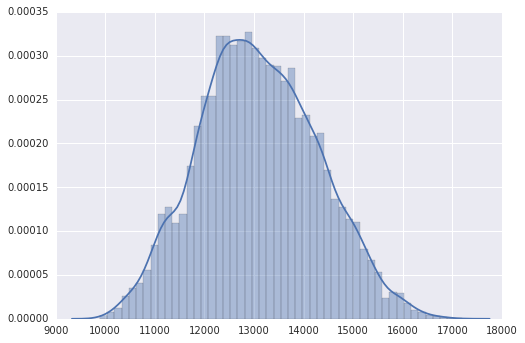

In [21]:
# Print some basic statistics and make some basic plot
print (np.mean(crsg_estimates[['capture_recapture_estimate']]))
print (np.median(crsg_estimates[['capture_recapture_estimate']]))
print (np.std(crsg_estimates[['capture_recapture_estimate']]))
import seaborn as sns
sns.distplot(crsg_estimates[['capture_recapture_estimate']]);

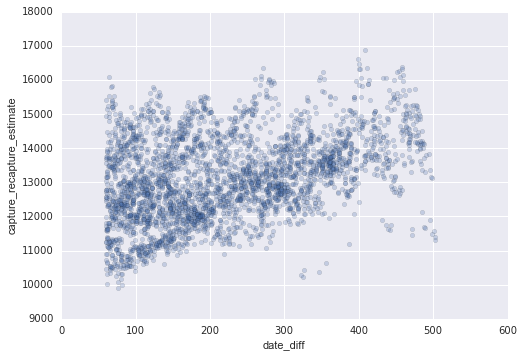

In [22]:
# Just for bookkeeping convert the variables to correct data types
crsg_estimates['groupA_start'] = pd.to_datetime(crsg_estimates['groupA_start'])
crsg_estimates['groupA_end'] = pd.to_datetime(crsg_estimates['groupA_end'])
crsg_estimates['groupB_start'] = pd.to_datetime(crsg_estimates['groupB_start'])
crsg_estimates['groupB_end'] = pd.to_datetime(crsg_estimates['groupB_end'])
crsg_estimates.sample(frac=0.25).plot.scatter(x='date_diff', y='capture_recapture_estimate', alpha=0.25)

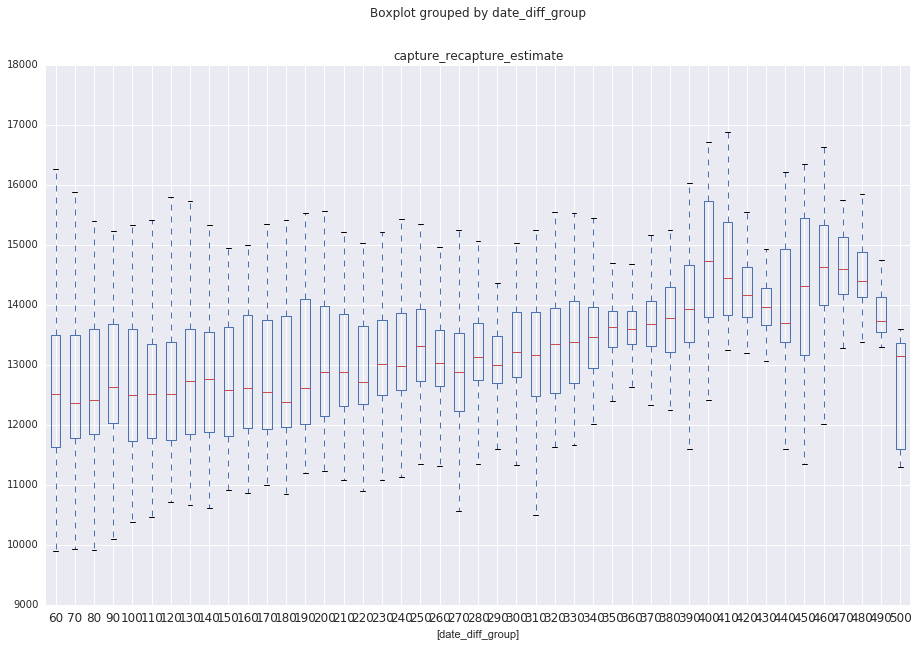

In [23]:
# Let's plot the same plot as above but using box plots, with the date_diff grouped in groups of 10 days
crsg_estimates['date_diff_group'] = list(map(lambda x : int(round(x , -1)), crsg_estimates['date_diff']))
crsg_estimates[['date_diff_group','capture_recapture_estimate']].boxplot(by='date_diff_group', figsize=(15,10))

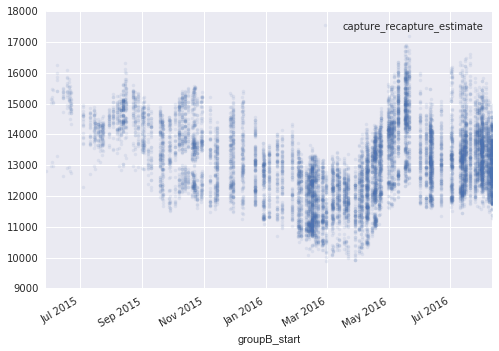

In [24]:
crsg_estimates.plot(x='groupB_start', y='capture_recapture_estimate', alpha=0.1, style=".")

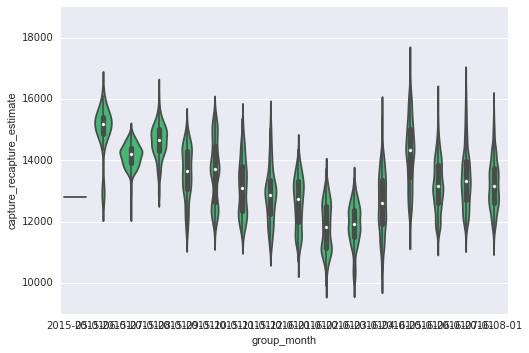

In [25]:
crsg_estimates['group_month'] = list(map(lambda dt : dt.replace(hour=0, minute=0, second=0, microsecond=0, day=1).date(), crsg_estimates['groupB_start']))
sns.violinplot(x='group_month', y='capture_recapture_estimate', data=crsg_estimates.sort_values(by='group_month'), color="#2ecc71")

# Quadratic regression to growth rate

In [26]:
# Then we try to fit the growth rate in quadratic form
z2 = np.polyfit(growth_df['diff'], growth_df['growth_rate'], 2)
p2 = np.poly1d(z2)
print (z2)
print (p2)

[ -8.85658058e-08   1.00630477e-04  -3.32311595e-03]
            2
-8.857e-08 x + 0.0001006 x - 0.003323


In [27]:
def growth2(t, l = z2):
    return z2[0]*t+z2[1]

In [28]:
def capture_recapture_with_survival_and_growth2(df, groupAstart, groupBstart, window):
    
    groupAend = groupAstart + datetime.timedelta(days=window)
    groupBend = groupBstart + datetime.timedelta(days=window)
    diff_days = (groupBstart - groupAstart).days
    workersA = getWorkerIDs(df, groupAstart, groupAend)
    workersB = getWorkerIDs(df, groupBstart, groupBend)
    union = workersA | workersB
    intersection = workersA & workersB
    if len(intersection) > 0:
        capture_recapture_estimate = len(workersA) * len(workersB) * survival(diff_days)  / len(intersection) * (1+ growth2(diff_days))
    else:
        capture_recapture_estimate = None

    return {
        "window" : window,
        "groupA_start" : groupAstart,
        "groupA_end" : groupAend,
        "groupB_start" : groupBstart,
        "groupB_end" : groupBend,
        "date_diff": diff_days,
        "workers_A" : len(workersA),
        "workers_B" : len(workersB),
        "workers_union" : len(union),
        "workers_intersection": len(intersection),
        "capture_recapture_estimate": capture_recapture_estimate
    }

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


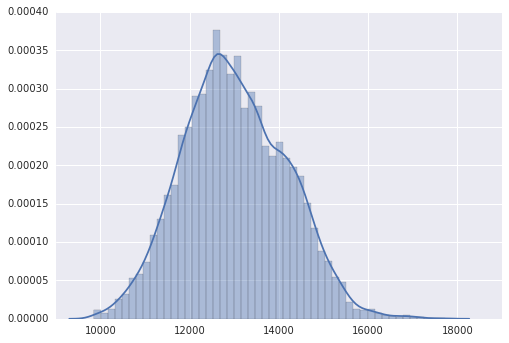

In [29]:
import random
sample_size_dates = 200
sample_dates = random.sample(list(df['hit_answered_date']), sample_size_dates)
sample_window = [30]
result = []
for groupAstart in sample_dates:
    for groupBstart in sample_dates:
        for window in sample_window:
            if groupBstart > groupAstart + datetime.timedelta(days=window) + datetime.timedelta(days=30) and groupBstart + datetime.timedelta(days=window) < maxDate:
                    r = capture_recapture_with_survival_and_growth2(df,groupAstart, groupBstart, window)
                    result.append(r)

crsg2_estimates = pd.DataFrame(result)
crsg2_estimates.head(5)
import seaborn as sns
sns.distplot(crsg2_estimates[['capture_recapture_estimate']]);

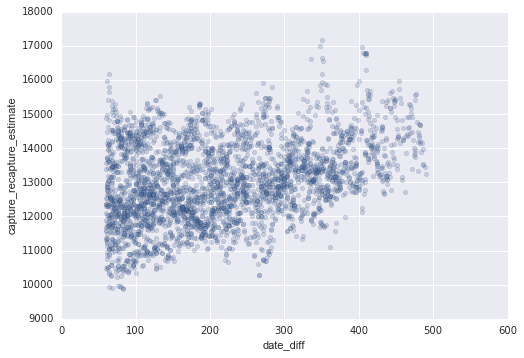

In [30]:
crsg2_estimates.sample(frac=0.25).plot.scatter(x='date_diff', y='capture_recapture_estimate', alpha=0.25)

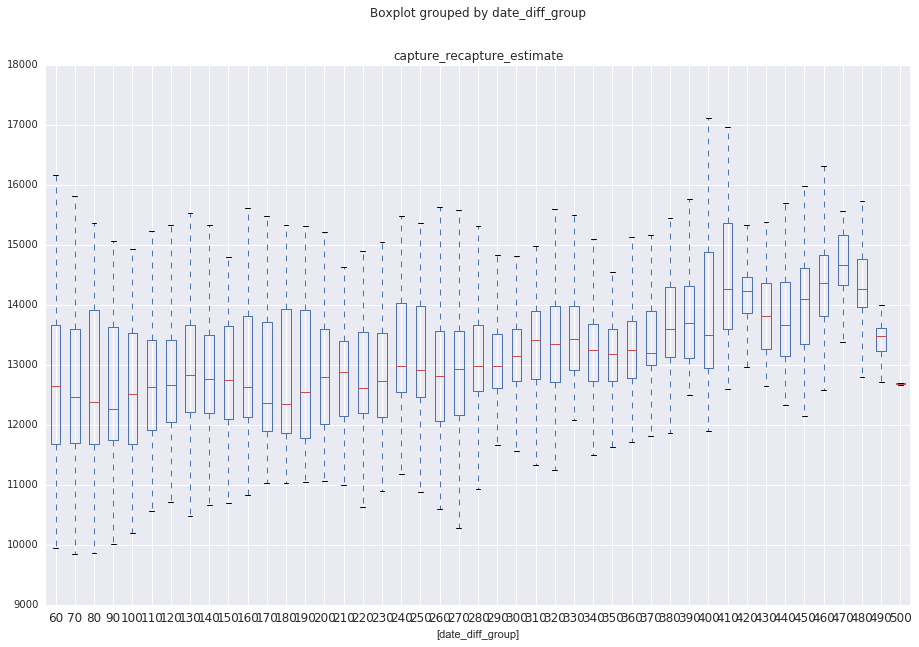

In [31]:
# Let's plot the same plot as above but using box plots, with the date_diff grouped in groups of 10 days
crsg2_estimates['date_diff_group'] = list(map(lambda x : int(round(x , -1)), crsg2_estimates['date_diff']))
crsg2_estimates[['date_diff_group','capture_recapture_estimate']].boxplot(by='date_diff_group', figsize=(15,10))

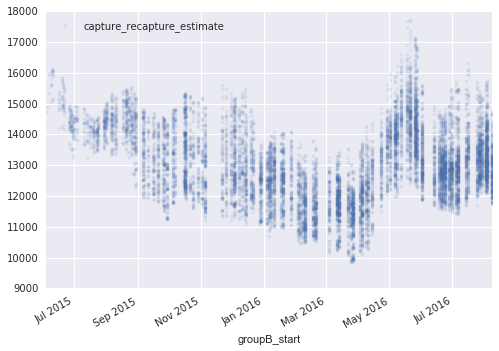

In [32]:
crsg2_estimates.plot(x='groupB_start', y='capture_recapture_estimate', alpha=0.1, style=".")

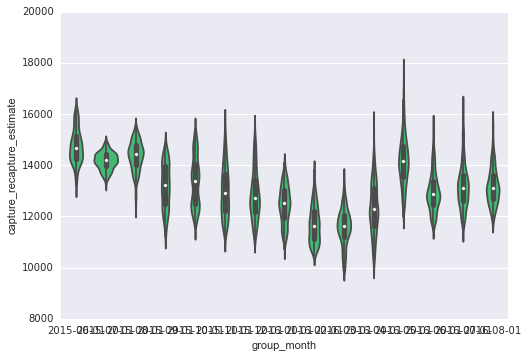

In [33]:
crsg2_estimates['group_month'] = list(map(lambda dt : dt.replace(hour=0, minute=0, second=0, microsecond=0, day=1).date(), crsg2_estimates['groupB_start']))
sns.violinplot(x='group_month', y='capture_recapture_estimate', data=crsg2_estimates.sort_values(by='group_month'), color="#2ecc71")

# Exponential regression to growth rate

In [34]:
# As the growth rate data contains number that less then or equal to 0, which makes it unable to make log computing 
# we first need to do the normalization
def Normalization(x,Max,Min):  
    x = (x - Min) / (Max - Min)+1;  
    return x;  

In [35]:
def DeNormalization(x,Max,Min):  
    x = (x-1) * (Max - Min) + Min;  
    return x;  

In [36]:
max = growth_df['growth_rate'][0]
min = growth_df['growth_rate'][0]
size = len(growth_df['growth_rate'])-1
for i in range(0,size):
    if growth_df['growth_rate'][i]<min: min = growth_df['growth_rate'][i];
    if growth_df['growth_rate'][i]>max: max = growth_df['growth_rate'][i];    
print(min)   
print(max)

-0.140625
0.171428571429


In [37]:
# Assuming an exponential growthing function S(t) = K * exp(lambda * t)
import math
import statsmodels.formula.api as sm
growth_df["growth_rate_norm"]=Normalization(growth_df['growth_rate'],max,min)
growth_df['log_growth_rate'] = list(map(lambda x : math.log(x), growth_df['growth_rate_norm']))
#result = sm.ols(formula="log_growth_rate ~ diff", data=growth_df).fit()
#print (result.params)

In [38]:
fit_K = math.exp(result.params['Intercept'])
fit_l = result.params['diff']

print ("K =", fit_K)
print ("labda =", fit_l)
print ("Half-life =", math.log(2)/fit_l)

AttributeError: 'list' object has no attribute 'params'

In [39]:
# Here we define the exponential growth rate function (Denormalization for the result)
def growth3(t, l = fit_l):
    return DeNormalization(np.exp(fit_l*t),max,min)

In [40]:
def capture_recapture_with_survival_and_growth3(df, groupAstart, groupBstart, window):
    
    groupAend = groupAstart + datetime.timedelta(days=window)
    groupBend = groupBstart + datetime.timedelta(days=window)
    diff_days = (groupBstart - groupAstart).days
    workersA = getWorkerIDs(df, groupAstart, groupAend)
    workersB = getWorkerIDs(df, groupBstart, groupBend)
    union = workersA | workersB
    intersection = workersA & workersB
    if len(intersection) > 0:
        capture_recapture_estimate = len(workersA) * len(workersB) * survival(diff_days)  / len(intersection) * (1+ growth3(diff_days))
    else:
        capture_recapture_estimate = None

    return {
        "window" : window,
        "groupA_start" : groupAstart,
        "groupA_end" : groupAend,
        "groupB_start" : groupBstart,
        "groupB_end" : groupBend,
        "date_diff": diff_days,
        "workers_A" : len(workersA),
        "workers_B" : len(workersB),
        "workers_union" : len(union),
        "workers_intersection": len(intersection),
        "capture_recapture_estimate": capture_recapture_estimate
    }

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


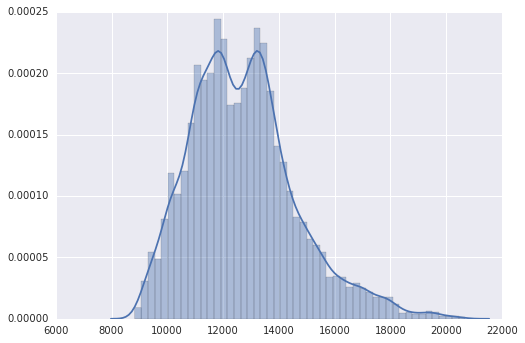

In [41]:
import random
sample_size_dates = 200
sample_dates = random.sample(list(df['hit_answered_date']), sample_size_dates)
sample_window = [30]
result = []
for groupAstart in sample_dates:
    for groupBstart in sample_dates:
        for window in sample_window:
            if groupBstart > groupAstart + datetime.timedelta(days=window) + datetime.timedelta(days=30) and groupBstart + datetime.timedelta(days=window) < maxDate:
                    r = capture_recapture_with_survival_and_growth3(df,groupAstart, groupBstart, window)
                    result.append(r)

crsg3_estimates = pd.DataFrame(result)
crsg3_estimates.head(5)
import seaborn as sns
sns.distplot(crsg3_estimates[['capture_recapture_estimate']]);